Note book to assess precipitation efficiency in Rosi's MPAS aquaplanet simulations

### Main settings

In [26]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import pickle
from scipy import stats
import numpy as np
import xarray as xr

In [27]:
data_path = '/glade/derecho/scratch/ruppert/tc-crfrad/pickle_out/'
# data_path = '../../../pickle_out/aquaplanet/'
test_names = ["CTL","HOMO_RAD","CLIM_RAD"]
# test_names = ["CTL","HOMO_RAD"]
ntest = len(test_names)
pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']
pclass_names_long = ['DeepC', 'Congest', 'Shallow', 'Stratiform', 'Anvil', 'DSA']
# pclass_names=["Deep", "Congestus", "Shallow", "Stratiform", "Anvil"]#, "DSA"] # DSA isn't there yet
nclass = len(pclass_names)

### Read data

In [28]:
# Get list of files
def get_file_list():
    # Get list of desired file times
    file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00',
                               6, dtype='datetime64[h]')
    file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]
    ntime = len(file_times)
    times = np.arange(ntime)/4 #+ 1.25
    return file_times, times

file_times, times = get_file_list()
ntime = len(times)

In [29]:
# grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"

# grid = xr.open_dataset(grid_path)
# latCell = np.degrees(grid.latCell)
# lonCell = np.degrees(grid.lonCell)
# areaCell = grid.areaCell

# #find indexes within desired latitudinal range
# # latbounds = [15, 20.0]
# ind_within_lat = np.where( (latCell >= latbounds[0]) & (latCell <= latbounds[1]) )[0]
# tot_cellcount = len(ind_within_lat)
# tot_cellcount

# For latbounds: 0, 10.0
# 5628214 grid cells

# For latbounds: 15, 20.0
# 2697020 grid cells
latbounds = [15, 20]
tot_cellcount = 2697020

# For latbounds: 0, 15.0
# 8396078 grid cells
# latbounds = [0, 15.0]
# tot_cellcount = 8396078

In [30]:
dims = (ntest, nclass, ntime)
pclass_area = np.full(dims, np.nan)
mu = np.full(dims, np.nan)
md = np.full(dims, np.nan)

for iexp in range(ntest):
    for it, time in enumerate(file_times):
        pickle_file = f"{data_path}VMF_pclass_{test_names[iexp]}_{time}_{str(int(latbounds[0]))}-{str(int(latbounds[1]))}.0.pickle"
        try:
            with open(pickle_file, 'rb') as f:
                file = pickle.load(f)
            for iname in pclass_names:
                # mu[expName][iname] = []
                # Read in variables from pickle
                # for iclass in range(nclass):
                pclass_area[iexp,:,it] = file[0]
                mu[iexp,:,it] = file[1]
                md[iexp,:,it] = file[2]
        except:
            pass

# for iclass in range(nclass):
#     # print(pclass_names[iclass], np.mean(pclass_area[0,iclass,:]))
#     # print(pclass_names[iclass], np.mean(mu[0,iclass,:]))
#     print(pclass_names[iclass], mu[0,iclass,-1])

In [31]:
mu[0,0,:]

array([2837.41772461, 2855.53344727, 3147.20922852, 2724.92480469,
       2755.00390625, 1962.91577148, 1863.61938477, 2090.54443359,
       1813.98205566, 1995.30700684, 2403.02416992, 2635.4519043 ,
       2638.39111328, 2438.94091797, 2745.77612305, 2857.45166016,
       2365.30322266, 2203.55224609, 2348.5456543 , 2340.54223633,
       2859.96240234, 3031.51782227, 3461.45800781, 3804.39501953,
       3443.79980469, 3085.60473633, 2920.55126953, 2425.93603516,
       2505.09545898, 2902.40551758, 2976.45776367, 3114.72680664,
       2969.84790039, 2474.51416016, 2494.99584961, 2281.56591797,
       2444.07324219, 2798.59521484, 2669.03198242, 2421.29321289])

#### PClass fraction

In [32]:
tot_area = np.sum(pclass_area, axis=1)
pclass_frac = np.copy(pclass_area)
for iclass in range(nclass):
    # pclass_frac1[:,iclass,:] = 1e2*pclass_area[:,iclass,:] / tot_area
    pclass_frac[:,iclass,:] = 1e2*pclass_area[:,iclass,:] / tot_cellcount
    # print(pclass_names[iclass],
    #       np.mean(pclass_area[0,iclass,:]),
    #       np.mean(pclass_frac1[0,iclass,:]),
    #       np.mean(pclass_frac2[0,iclass,:]))

### Plotting

#### Time series

In [33]:
# Function to compute running mean
def running_mean_conf(time_series):
    nd_smooth    = 6 # days
    nd_window_ci = 6
    # nd_smooth    = 20 # days
    # nd_window_ci = 20
    ntpday = 4 # timesteps per day
    window_size = nd_smooth*ntpday  # Adjust as needed
    window_size_ci = nd_window_ci*ntpday  # Adjust as needed
    tser_smooth = np.convolve(time_series, np.ones(window_size) / window_size, mode='valid')
    tser_ci = np.convolve(time_series, np.ones(window_size_ci) / window_size_ci, mode='valid')
    # Compute standard error of the mean
    standard_error = stats.sem(time_series)  # Standard error of the original data
    z_score = 1.96 # Z-score for 95% confidence interval
    confidence_interval = z_score * standard_error  # 95% confidence interval
    # confidence_interval = np.zeros_like(tser_ci)
    # # for i in range(len(tser_smooth)):
    # for i in range(len(tser_ci)):
    #     subset = time_series[i:i+window_size_ci]
    #     standard_error = stats.sem(subset)
    #     confidence_interval[i] = z_score * standard_error
    #     # Q1 = np.percentile(subset, 25)
    #     # Q3 = np.percentile(subset, 75)
    #     # IQR = Q3 - Q1
    #     # confidence_interval[i] = IQR/2
    return tser_smooth, confidence_interval, window_size, tser_ci, window_size_ci

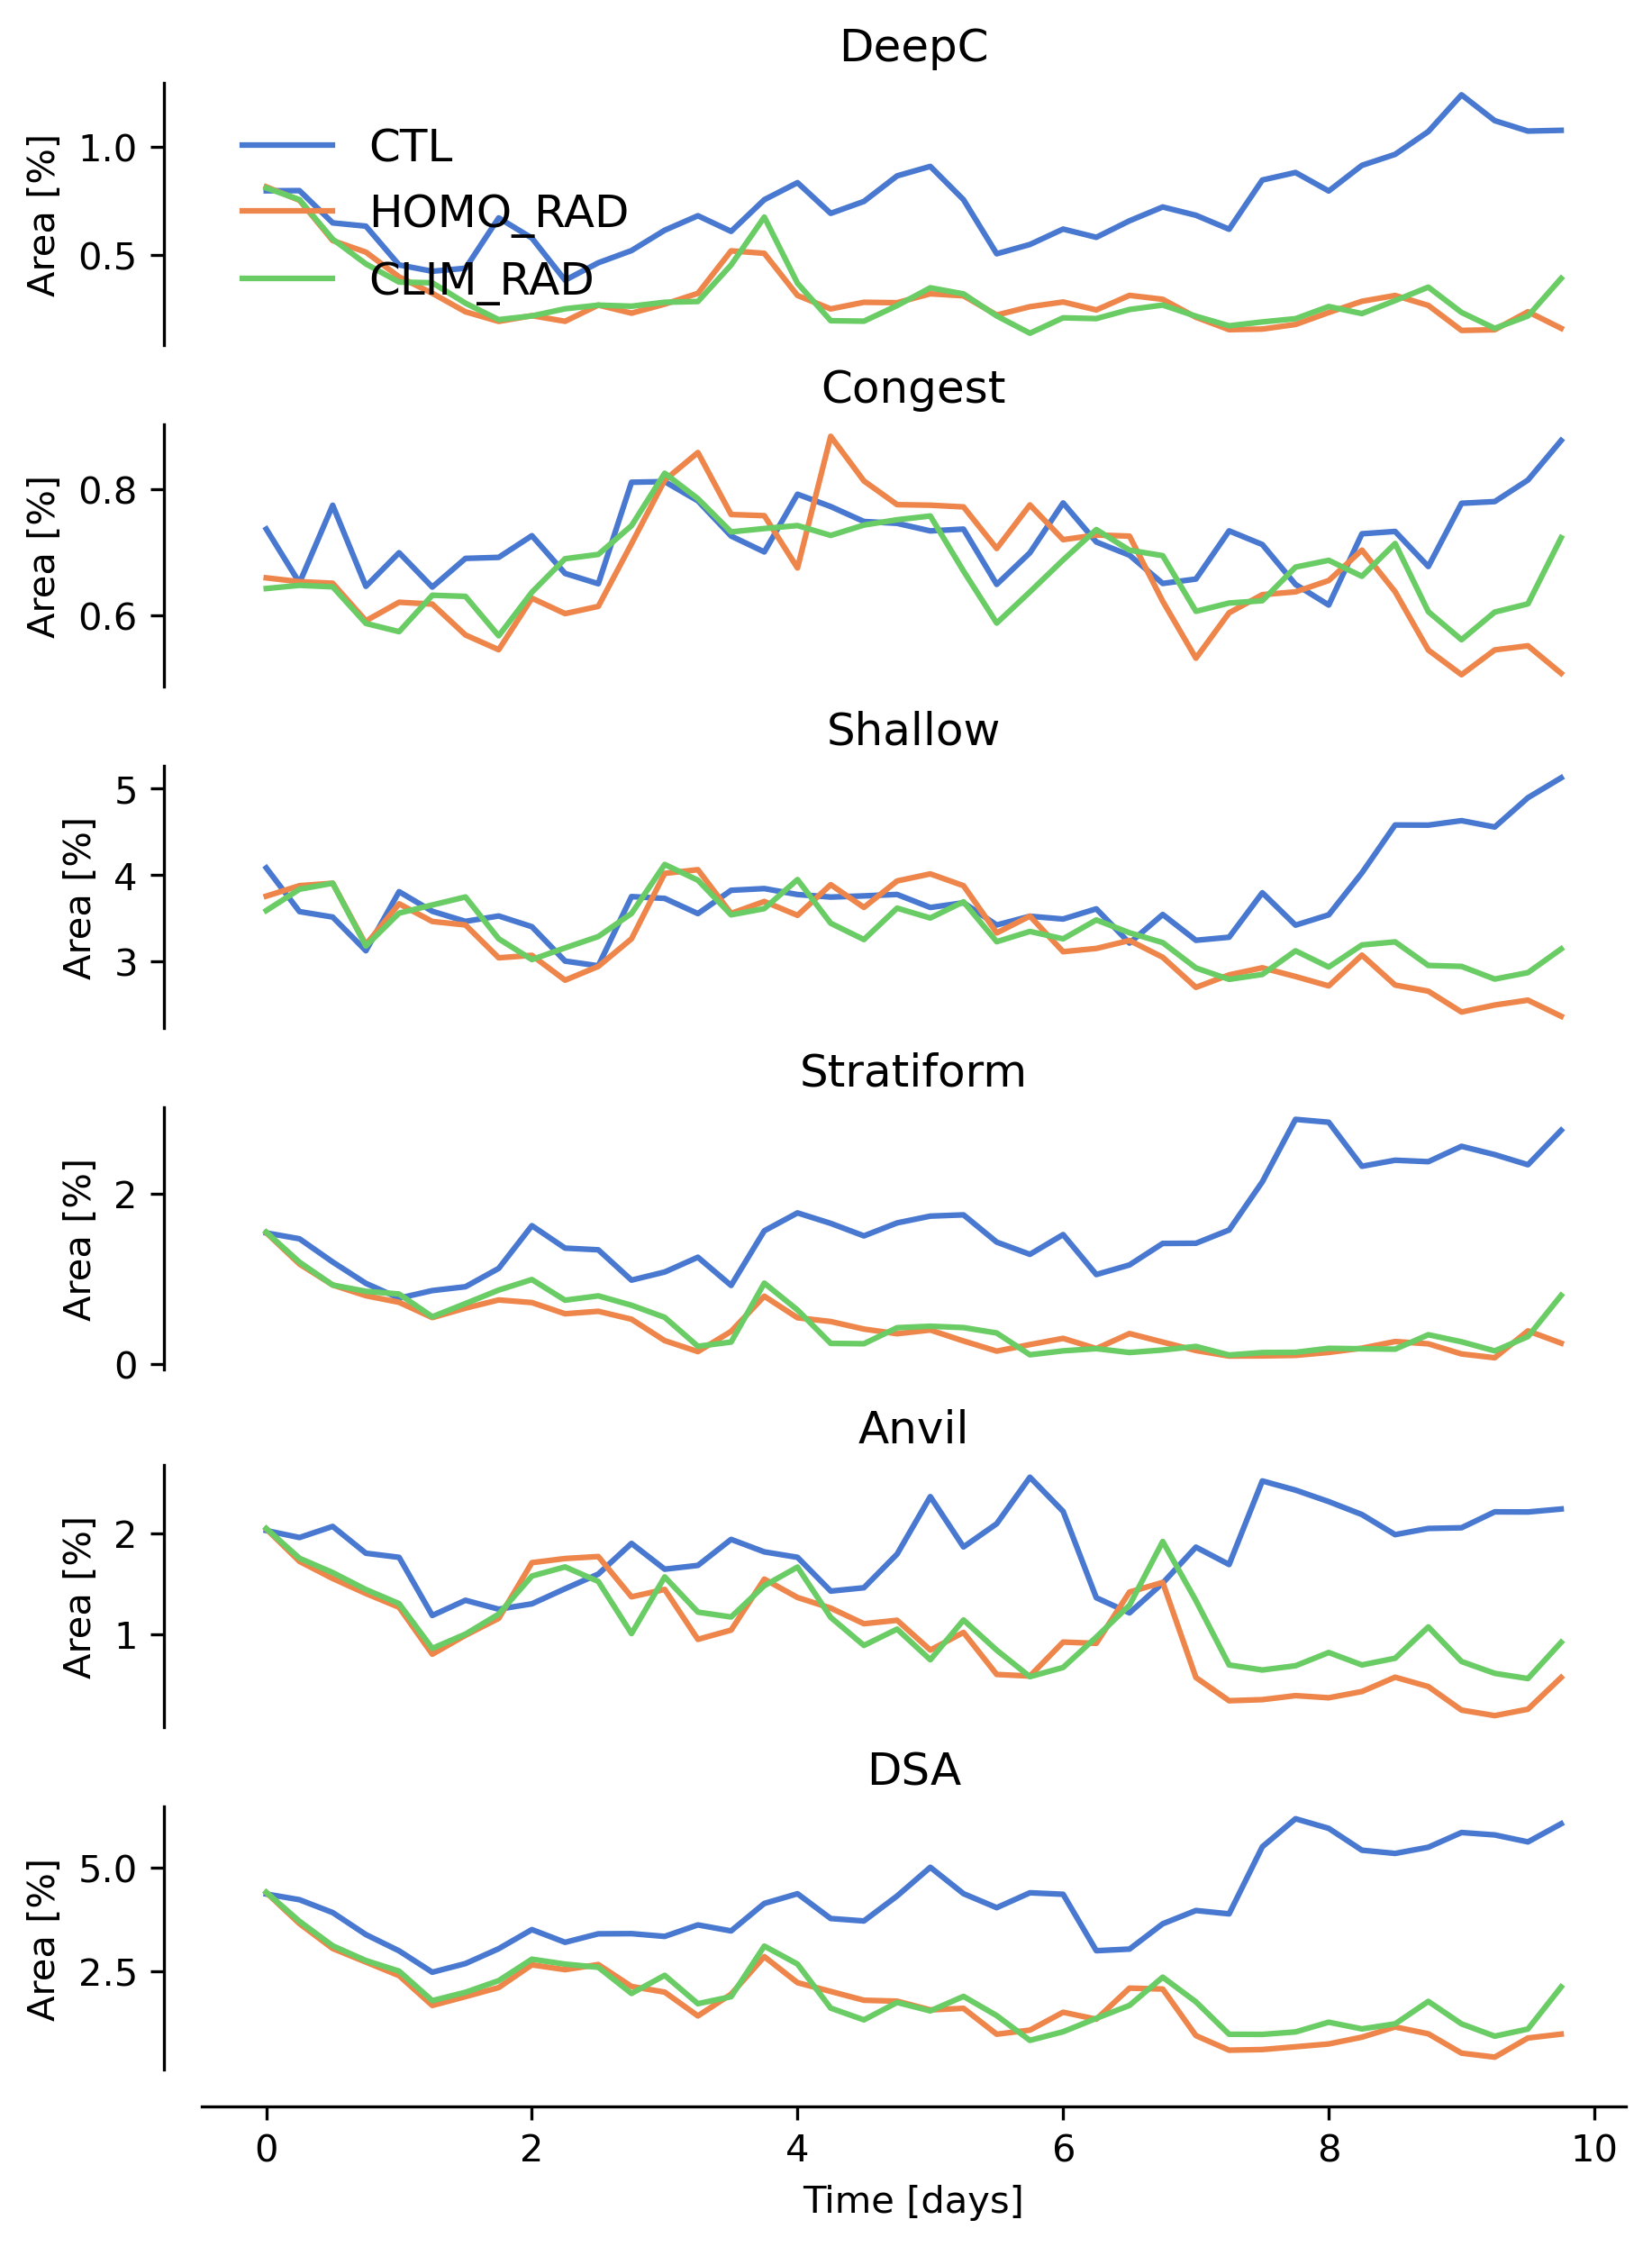

In [34]:
# create figure
fig_x = 6
fig_y = 1.2*nclass + 1
fig, axs = plt.subplots(nclass,1, figsize=(fig_x,fig_y), layout="constrained", dpi=300)
sns.set_palette('muted')

for iclass, iax in enumerate(axs):

    iax.set_title(pclass_names_long[iclass])
    iax.set_ylabel('Area [%]')

    for iexp in range(ntest):
        tser = pclass_frac[iexp,iclass,:]
        iax.plot(times, tser, linewidth=1.5, label=test_names[iexp])
        # ivar_smooth, confidence_interval, nwindow = running_mean_conf(pltvar)
        # x_smoothed = times[nwindow//2:-nwindow//2+1]
        # axs.plot(x_smoothed, ivar_smooth, linewidth=1.5, label=test_names[itest])
        # axs.fill_between(x_smoothed,
        #     ivar_smooth - confidence_interval,
        #     ivar_smooth + confidence_interval,
        #     alpha=0.4,label="95% CI")

sns.despine(offset=10,ax=axs[-1])
for iaxs in axs[:-1]:
    sns.despine(offset=10,ax=iaxs, bottom=True)
    # Remove x-ticks
    iaxs.set_xticks([])

axs[-1].set_xlabel('Time [days]')
axs[0].legend(loc="lower left", frameon=False, fontsize=12)#, bbox_to_anchor=(0.05, 0.05))
plt.show()

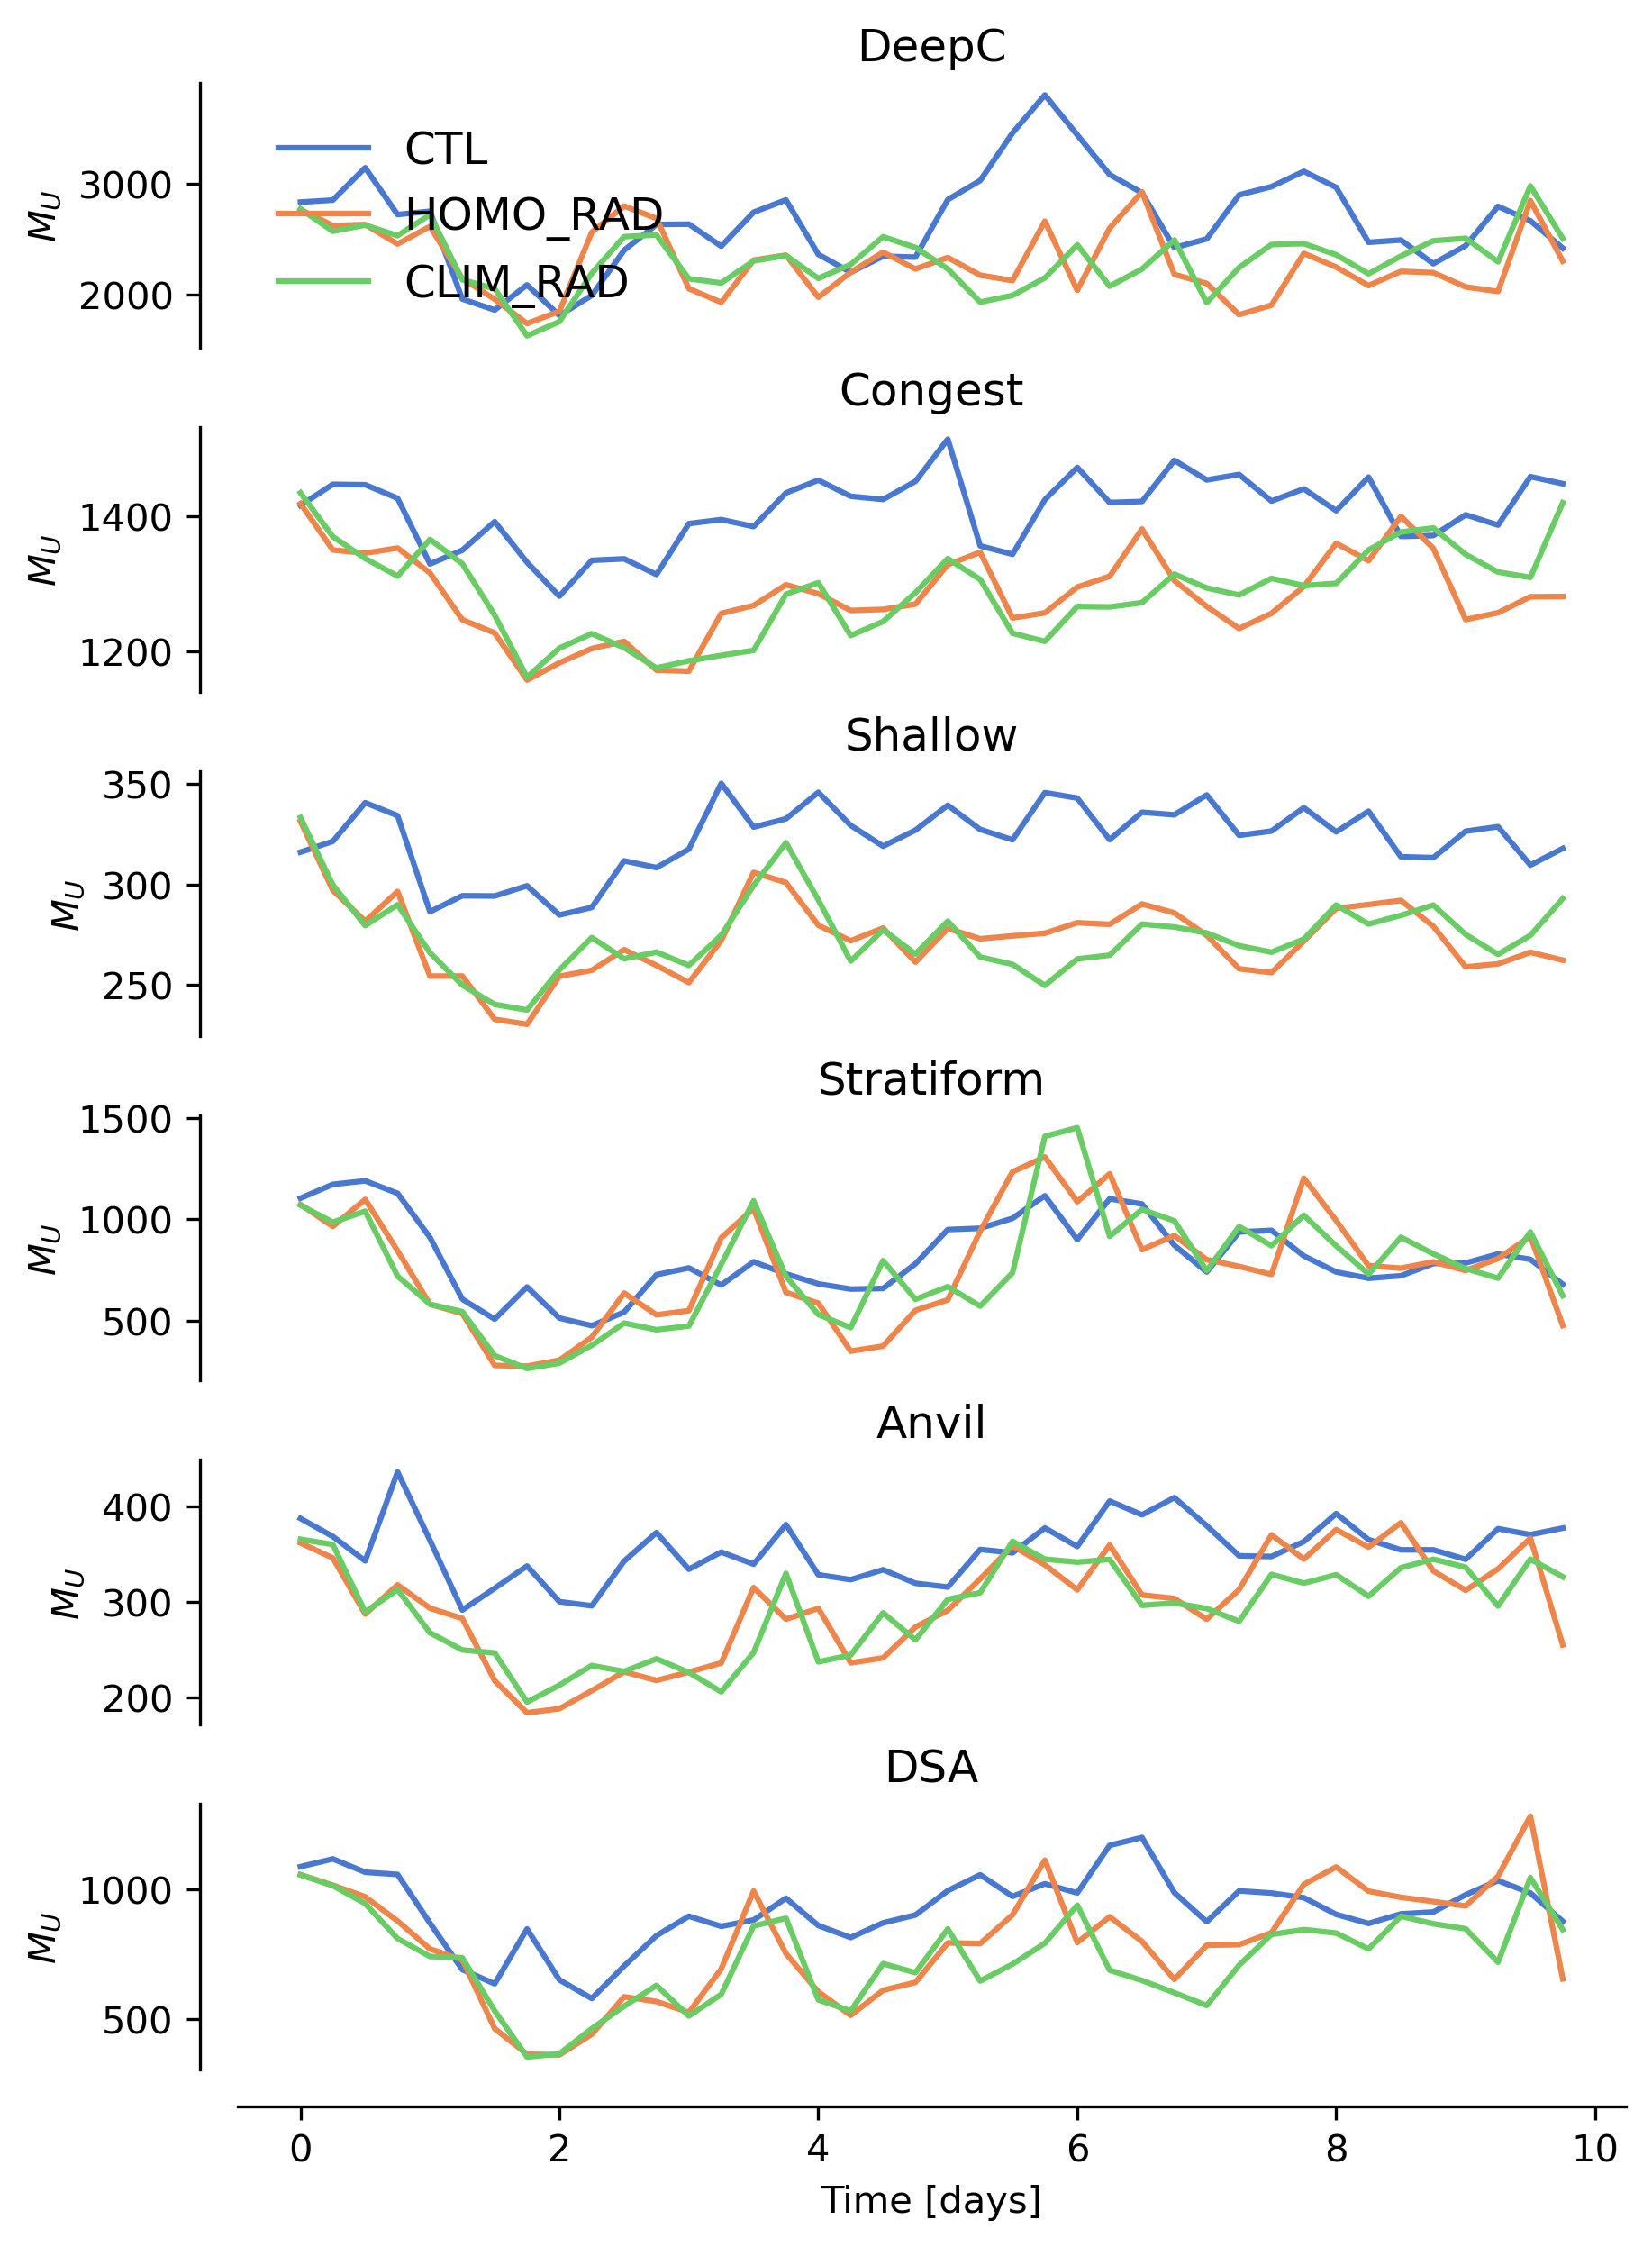

In [35]:
# create figure
fig_x = 6
fig_y = 1.2*nclass + 1
fig, axs = plt.subplots(nclass,1, figsize=(fig_x,fig_y), layout="constrained", dpi=300)
sns.set_palette('muted')

for iclass, iax in enumerate(axs):

    iax.set_title(pclass_names_long[iclass])
    iax.set_ylabel('$M_U$')

    for iexp in range(ntest):
        tser = mu[iexp,iclass,:]
        iax.plot(times, tser, linewidth=1.5, label=test_names[iexp])
        # ivar_smooth, confidence_interval, nwindow = running_mean_conf(pltvar)
        # x_smoothed = times[nwindow//2:-nwindow//2+1]
        # axs.plot(x_smoothed, ivar_smooth, linewidth=1.5, label=test_names[itest])
        # axs.fill_between(x_smoothed,
        #     ivar_smooth - confidence_interval,
        #     ivar_smooth + confidence_interval,
        #     alpha=0.4,label="95% CI")

sns.despine(offset=10,ax=axs[-1])
for iaxs in axs[:-1]:
    sns.despine(offset=10,ax=iaxs, bottom=True)
    # Remove x-ticks
    iaxs.set_xticks([])

axs[-1].set_xlabel('Time [days]')
axs[0].legend(loc="lower left", frameon=False, fontsize=12)#, bbox_to_anchor=(0.05, 0.05))
plt.show()

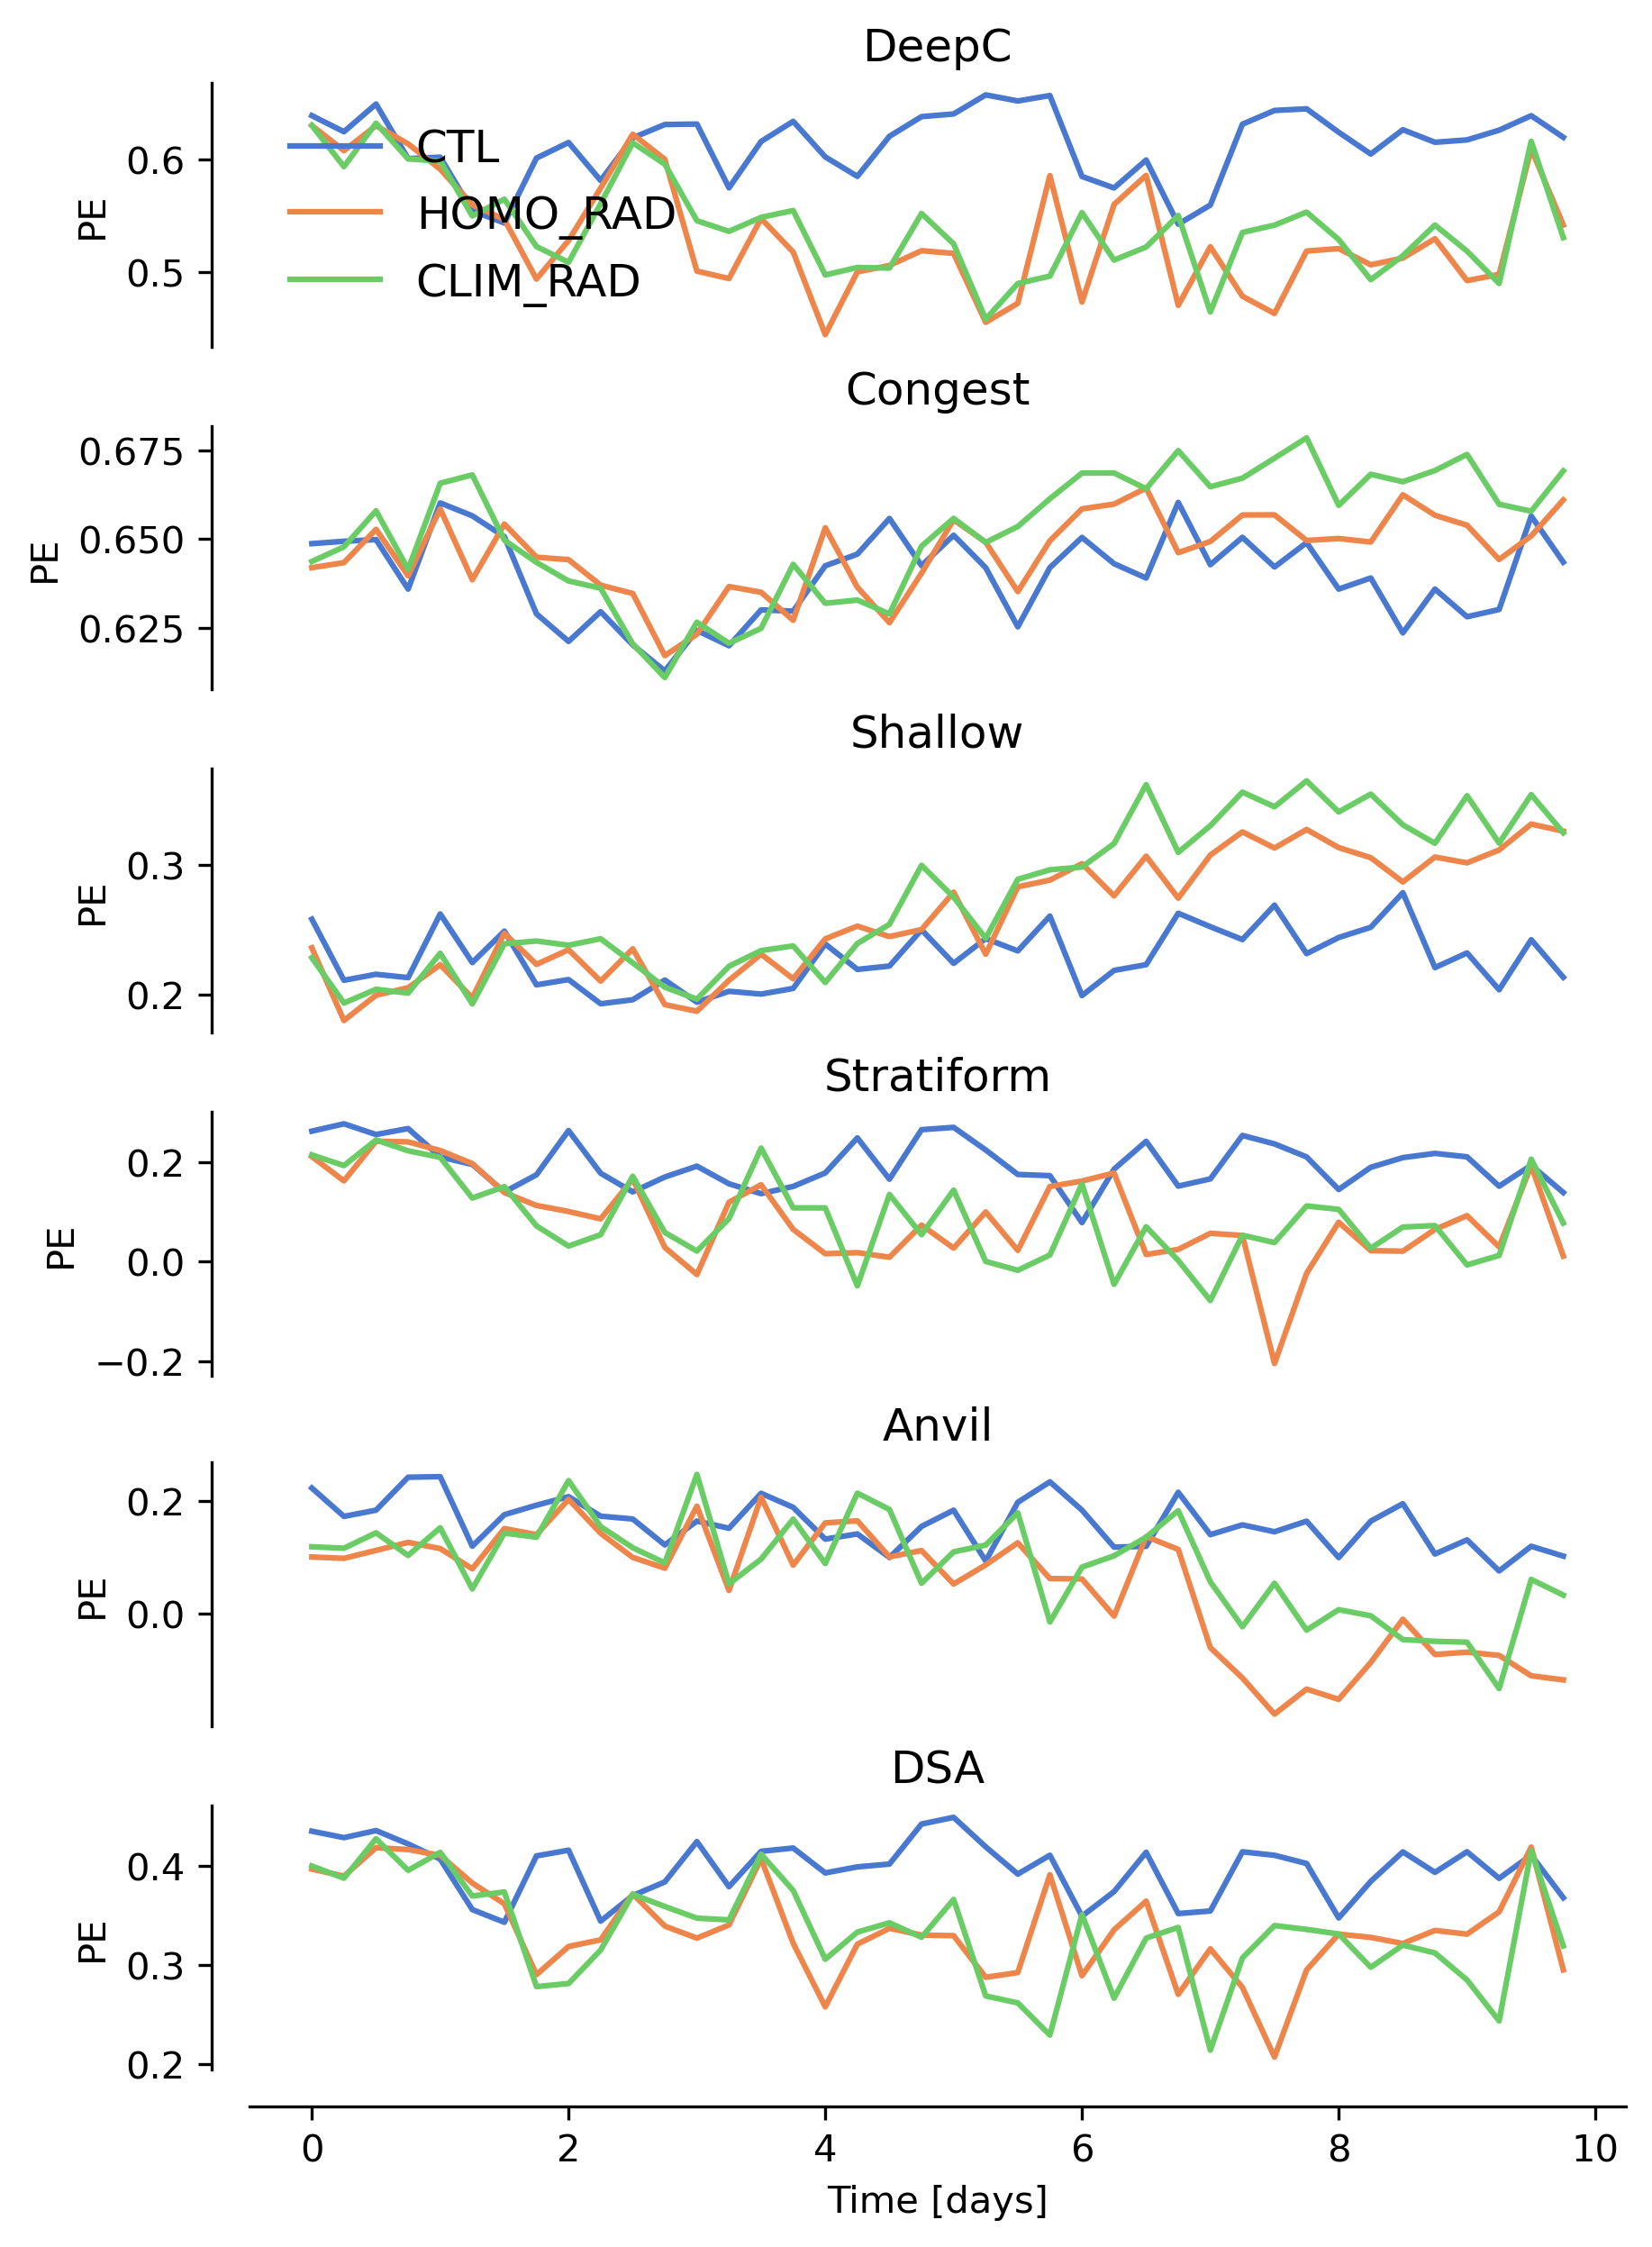

In [36]:
# create figure
fig_x = 6
fig_y = 1.2*nclass + 1
fig, axs = plt.subplots(nclass,1, figsize=(fig_x,fig_y), layout="constrained", dpi=300)
sns.set_palette('muted')

for iclass, iax in enumerate(axs):

    iax.set_title(pclass_names_long[iclass])
    iax.set_ylabel('PE')

    for iexp in range(ntest):
        tser = (1 - (-md/mu))[iexp,iclass,:]
        iax.plot(times, tser, linewidth=1.5, label=test_names[iexp])
        # ivar_smooth, confidence_interval, nwindow = running_mean_conf(pltvar)
        # x_smoothed = times[nwindow//2:-nwindow//2+1]
        # axs.plot(x_smoothed, ivar_smooth, linewidth=1.5, label=test_names[itest])
        # axs.fill_between(x_smoothed,
        #     ivar_smooth - confidence_interval,
        #     ivar_smooth + confidence_interval,
        #     alpha=0.4,label="95% CI")

sns.despine(offset=10,ax=axs[-1])
for iaxs in axs[:-1]:
    sns.despine(offset=10,ax=iaxs, bottom=True)
    # Remove x-ticks
    iaxs.set_xticks([])

axs[-1].set_xlabel('Time [days]')
axs[0].legend(loc="lower left", frameon=False, fontsize=12)#, bbox_to_anchor=(0.05, 0.05))
plt.show()

#### Boxplots

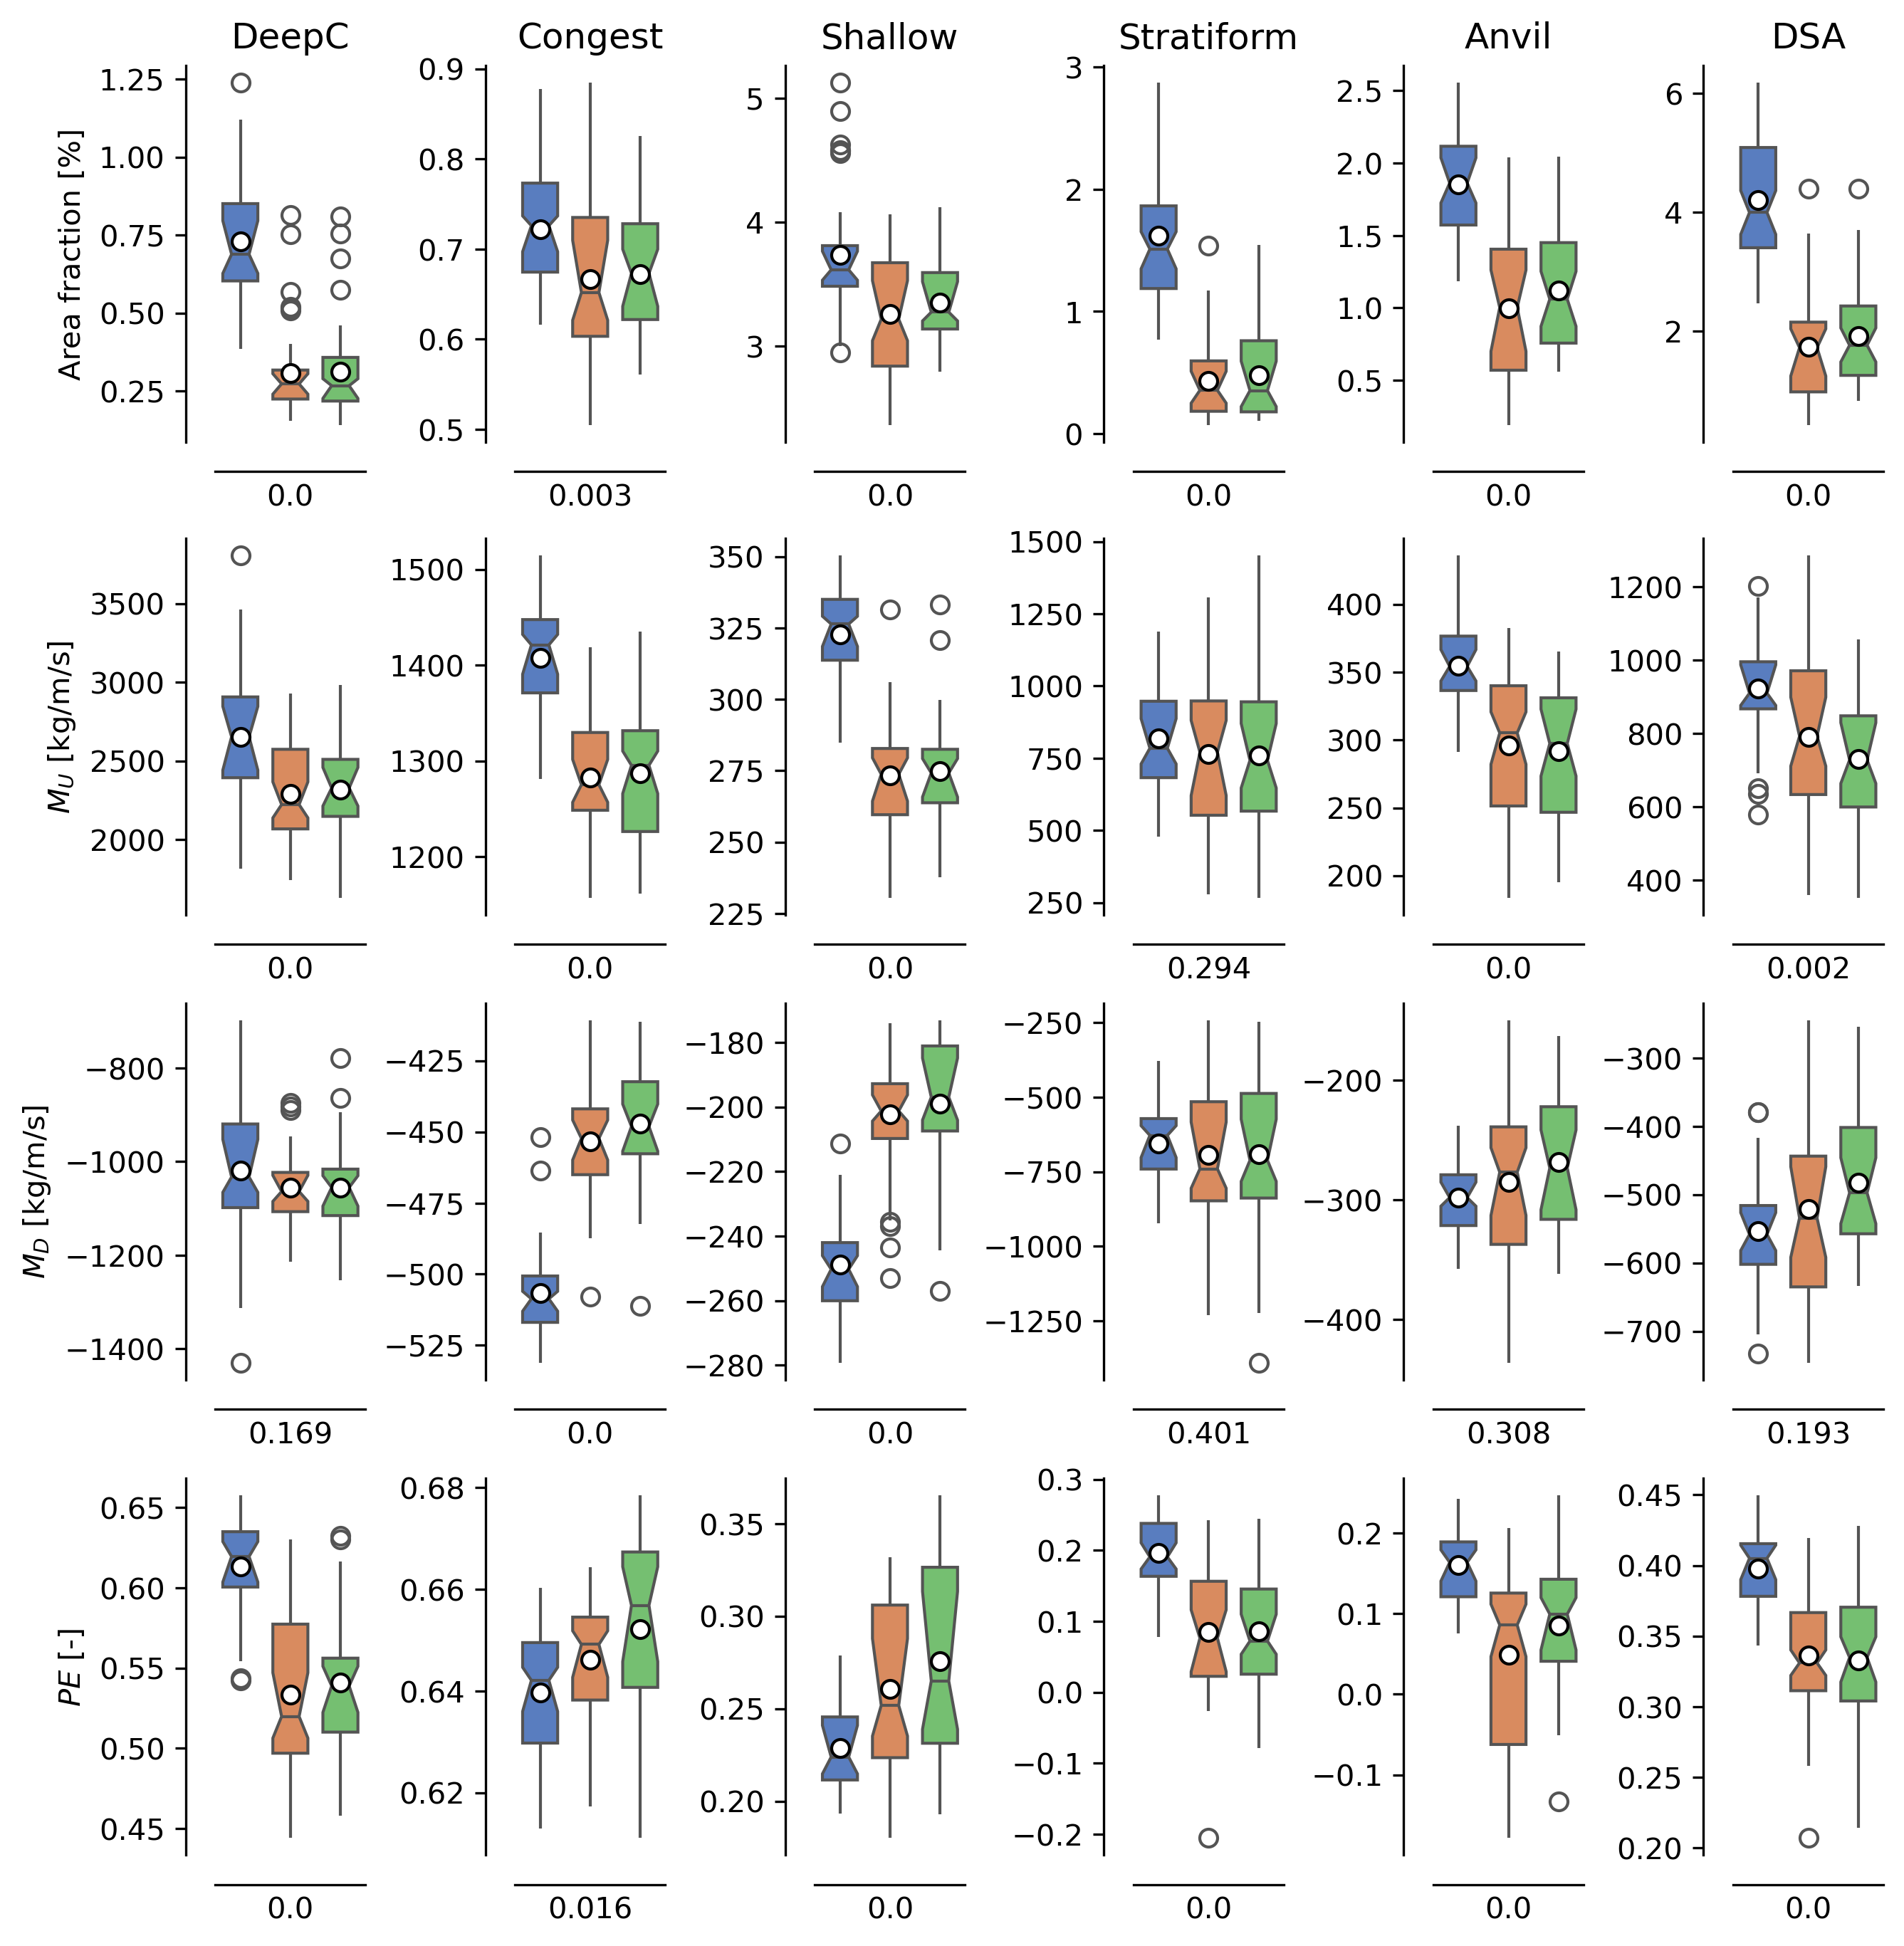

In [37]:
from scipy.stats import ttest_ind

def plot_boxplots(pltvar, axs, do_legend=False):
      colors = sns.color_palette('muted', n_colors=ntest)
      for iclass, iax in enumerate(axs):
            sns.boxplot([pltvar[iexp,iclass,:] for iexp in range(pltvar.shape[0])],
                        width=0.7, showmeans=True,
                        meanprops={"marker":"o", "markerfacecolor":"white",
                              "markeredgecolor":"black", "markersize":"6"},
                        palette=colors,
                        ax=iax, notch=True, showcaps=False, bootstrap=10000,
                        showfliers=True,)
            sns.despine(ax=iax, bottom=True)

            # Add t-test
            t_stat, p_value = ttest_ind(pltvar[0,iclass,:],
                                    pltvar[1,iclass,:],
                                    equal_var=True)
            iax.text(0.5, -0.11, str(np.round(p_value, 3)),
                     ha='center', va='top', transform=iax.transAxes)#, fontsize=10)
      # if do_legend:
      #       axs[-1].legend(loc="upper right", frameon=False, fontsize=12, labels=test_names, bbox_to_anchor=(1.15, 0.5))
      #       handles = [plt.Line2D([0], [0], color=colors[i], lw=10) for i in range(ntest)]
      #       axs[-1].legend(handles=handles, labels=test_names, loc="center right", frameon=False,
      #                      fontsize=12, bbox_to_anchor=(5.0, 0.5))
      return axs

# it_max = len(times)
it_max = np.max(np.where(~np.isnan(pclass_frac[2,0,:]))[0]) + 1

# create figure
fig_x = 1.3*nclass + 1
fig_y = 9
fig, axs = plt.subplots(4,nclass, figsize=(fig_x,fig_y), layout="constrained", dpi=300)

# PClass Area
pltvar = pclass_frac
ytitle = 'Area fraction [%]'
irow = 0
axs[irow, 0].set_ylabel(ytitle)
# plot_boxplots(pltvar, axs.flatten()[0:nclass], ntest, it_max, ytitle, do_legend=True)
axs[irow,:] = plot_boxplots(pltvar[:,:,:it_max], axs[irow,:])

# M_U
pltvar = mu
ytitle = '$M_U$ [kg/m/s]'
# plot_boxplots(pltvar, axs.flatten()[nclass:nclass*2], ntest, it_max, ytitle, do_legend=True)
irow = 1
axs[irow, 0].set_ylabel(ytitle)
axs[irow,:] = plot_boxplots(pltvar[:,:,:it_max], axs[irow,:])

# M_D
pltvar = md
ytitle = '$M_D$ [kg/m/s]'
# plot_boxplots(pltvar, axs.flatten()[nclass*2:nclass*3], ntest, it_max, ytitle)
irow = 2
axs[irow, 0].set_ylabel(ytitle)
axs[irow,:] = plot_boxplots(pltvar[:,:,:it_max], axs[irow,:])

# PE
pltvar = 1 - (-md/mu)
ytitle = '$PE$ [-]'
# plot_boxplots(pltvar, axs.flatten()[nclass*3:nclass*4], ntest, it_max, ytitle)
irow = 3
axs[irow, 0].set_ylabel(ytitle)
axs[irow,:] = plot_boxplots(pltvar[:,:,:it_max], axs[irow,:])

for iclass in range(nclass):
      axs[0,iclass].set_title(pclass_names_long[iclass])

for iaxs in axs.flatten():
      sns.despine(offset=10,ax=iaxs, top=True, right=True)
      iaxs.set_xticks([])

# axs[1,nclass-1].legend(loc="upper right", labels=test_names,
#                        frameon=False, fontsize=12, bbox_to_anchor=(1.15, 0.5))

plt.show()